<h1 align=center><font size = 8><font color = teal>Best Restaurant Locations in</font></h1>
<h1 align=center><font size = 8><font color = teal>Manhattan</font></h1>

<a align=left href="https://pointtwodesign.com"><img src = "https://aihkcdnstoragep01.blob.core.windows.net/pgl-release/Images/ArticleImages/19/19156.jpg" width = 500 height = 100> </a>

# 1- Introduction

Manhattan is one of the five boroughs that make up New York City, and is the center of the New York metropolitan area. It is also located over the same area as a county of New York state called New York County. Although it is the smallest borough, it is the most densely populated borough.
Manhattan is an important commercial, financial, and cultural center of both the United States and the world,it has many famous landmarks, tourist attractions, museums, and universities.
In this project we'll identify the best Neighborhoods in Manhattan to open a resturant in Manhattan, this will be suitable for investors who are looking for the best place in Manhattan for a resturant that will be with a high profit potentials.

# 2- Data

To check the best Neighborhoods in Manhattan for a restaurant, there are alot of factors that will affect this purpose, but as we'll make a study for a general type restaurant, so we'll focus only on the following aspects:
the competition and Prking availability.
the datasets to be used are as following:

1- Newyork data : a dataset that contains Newyork's boroughs and neighborhood along with it's coordinates, we'll slice the dataset on borough column, to get the related data to manhattan only.

2- Manhattan venues : a dataset includes all venues in each neighborhood, latitude & longitude for each neighborhood, venue names and it's category.
we'll do some explatory analysis on the dataset to get the most common venues in each neighborhood, then merge it to the manhattan data that created from above.

3- Parking Meters GPS Coordinates and Status : a dataset that contains parking meters number, latitude & longitude, and borough, from "NYC opendata".
we'll use Nominatim reverse geocoding service, to convert the coordinates to an address then to the corresponding Neighborhood from that address, then we'll group the Neighborhoods by the count of parking meters.
then we'll merge it to the above manhattan data, and then prepare it for the clustering model that we'll use to group the neighborhoods by there similarty to each other, and based on that we'll check the clusters and identify which groups are suitable for our purpose.

# 3- Methodology

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
#!conda update -n base -c defaults conda
#from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


Let's download Neywork data.

In [2]:
#!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
import urllib.request
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
filename = 'newyork_data.json'
urllib.request.urlretrieve(url, filename)
print('Data downloaded!')

Data downloaded!


Now we load and explore the data

- Let's start by Newyork data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [4]:
# Transforming the data into Pandas dataframe.
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
# looping through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']    
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Let's slice the dataframe to include Manhattan boroughs only.

In [5]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print('Manhattan has {} Neighborhood'.format(manhattan_data.shape[0]))
manhattan_data.head()

Manhattan has 40 Neighborhood


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


- Now let's download and explore Manhattan venues dataset.

In [6]:
manhattan_venues = pd.read_json('manhattan_venues.json')
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [7]:
print('Manhattan has {} Neighborhood with total {} venues'.format(len(manhattan_venues['Neighborhood'].unique()),
                                                                  manhattan_venues.shape[0]))

Manhattan has 40 Neighborhood with total 3240 venues


- Let's identify the nature of each Neighborhood by getting the top 5 most common venues in each neighborhood.

In [8]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating 

we'll group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [9]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating 

Now let's create a new dataframe and display the top 5 venues for each neighborhood.

In [10]:
# define a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# create the sorted data frame
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood'] # create columns according to number of top venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Gym,Clothing Store,Hotel
1,Carnegie Hill,Coffee Shop,Café,Bar,Italian Restaurant,Pizza Place
2,Central Harlem,African Restaurant,Seafood Restaurant,Cosmetics Shop,Bar,French Restaurant
3,Chelsea,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant
4,Chinatown,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant


- Now let's merge neighborhoods_venues_sorted data with Manhattan data.

In [11]:
manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Gym
3,Manhattan,Inwood,40.867684,-73.921210,Mexican Restaurant,Café,Restaurant,Lounge,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant


- Next step is to get number of parkings available in each neighborhood.
- so let's download the Parking Meters GPS Coordinates and Status dataset and explore it. 

As most of the Datasets, Parkint meters data contains only coordinates, so we had to convert those coordinates and get the Neighborhood.
to do this we used reverse geocoding service from Nominatim.
the following line of codes commented because the reverese geocoding takes some time with 5000 coordinates in our dataset.

In [12]:
#lats=manhattan_parking['LAT'].to_list()
#lons=manhattan_parking['LONG'].to_list()
# Creating a zip with latitudes and longitudes
#coords=list(zip(lats,lons))

In [13]:
#geolocator = Nominatim(user_agent="my_test_app") 
#neighboors= []
#for i in range(len(coords)):
 #   location = geolocator.reverse(coords[i])
  #  neighboor=location.raw['address'].get('neighbourhood')
  #  neighboors.append(neighboor)

- After we got the corresponding Neighborhood to each coordinate, we saved it to a new CSV file named "manhattan_parking", so let's load the file and start exploring it.

In [14]:
manhattan_parking = pd.read_csv('manhattan_parking.csv')
manhattan_parking = manhattan_parking[['MeterNo','LAT','LONG','Neighborhood']]
manhattan_parking.head()

,MeterNo,LAT,LONG,Neighborhood
0,1068277,40.863244,-73.925681,Fort George
1,1068276,40.862876,-73.925443,Fort George
2,1068275,40.862783,-73.925016,Fort George
3,1068274,40.862670,-73.924983,Fort George
4,1068273,40.862289,-73.925066,Fort George


- Let's check if there are empty values in Neighborhood coloumn, and remove it if any.

In [15]:
manhattan_parking['Neighborhood'].isnull().value_counts()

False    4833
True      133
Name: Neighborhood, dtype: int64

In [16]:
manhattan_parking = manhattan_parking.dropna(how='any', axis=0)
manhattan_parking['Neighborhood'].isnull().value_counts()

False    4833
Name: Neighborhood, dtype: int64

- Now we'll group the dataset by Neighborhood.

In [17]:
manhattan_parking = manhattan_parking.groupby('Neighborhood').count()

In [18]:
manhattan_parking.drop(['LONG','LAT'], axis=1, inplace= True)
manhattan_parking = manhattan_parking.reset_index()
manhattan_parking = manhattan_parking.rename(columns={'MeterNo': 'Parking_No.'})
manhattan_parking.head()

,Neighborhood,Parking_No.
0,Alphabet City,3
1,Battery Park City,2
2,Brighton Beach,1
3,Bronx County,2
4,Carnegie Hill,79


- Let's merge the parking data with the manhattan merged data.

In [19]:
manhattan_merged = pd.merge(manhattan_merged, manhattan_parking, on="Neighborhood", how='left')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
0,Manhattan,Marble Hill,40.876551,-73.910660,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,NaN
1,Manhattan,Chinatown,40.715618,-73.994279,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant,74.0
2,Manhattan,Washington Heights,40.851903,-73.936900,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Gym,NaN
3,Manhattan,Inwood,40.867684,-73.921210,Mexican Restaurant,Café,Restaurant,Lounge,Chinese Restaurant,32.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,44.0


- Replace the Nan values in Parking_No. column with the mean value.

In [20]:
manhattan_merged['Parking_No.'] = manhattan_merged['Parking_No.'].fillna(int(manhattan_merged['Parking_No.'].mean()))
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
0,Manhattan,Marble Hill,40.876551,-73.910660,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,72.0
1,Manhattan,Chinatown,40.715618,-73.994279,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant,74.0
2,Manhattan,Washington Heights,40.851903,-73.936900,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Gym,72.0
3,Manhattan,Inwood,40.867684,-73.921210,Mexican Restaurant,Café,Restaurant,Lounge,Chinese Restaurant,32.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,44.0


- Merge the parking data to manhattan_grouped dataset, to prepare a data set for clustering model.

In [21]:
manhattan_clustering = pd.merge(manhattan_grouped, manhattan_parking, on="Neighborhood", how='left')
manhattan_clustering.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating 

In [22]:
manhattan_clustering['Parking_No.'] = manhattan_clustering['Parking_No.'].fillna(int(manhattan_clustering['Parking_No.'].mean()))
manhattan_clustering.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating 

- Now our dataset is ready, let's build a clustering model for Manhattan Neighborhoods.

- We'll use K-means to cluster the Neighborhoods, and to do that let's get the optimal value of K.
- Elbow method :

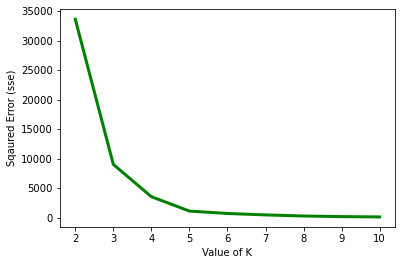

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
sse =[]
Kmax= 10
manhattan_clustering = manhattan_clustering.drop('Neighborhood', 1)
for k in range(2, Kmax+1):
    KM = KMeans(n_clusters = k, max_iter = 500)
    KM.fit(manhattan_clustering)
      
    # calculates squared error
    sse.append(KM.inertia_)     

# plot the sse against K values
plt.plot(range(2, Kmax+1), sse, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Sqaured Error (sse)")
plt.show() # clear the plot

- Silhouette_score method :

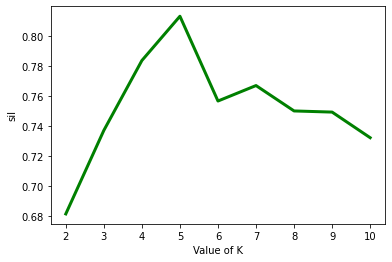

In [24]:
# getting the optimal value of K at highest silhouette_score
from sklearn.metrics import silhouette_score

sil = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, Kmax+1):
    kmeans = KMeans(n_clusters = k, max_iter = 500).fit(manhattan_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(manhattan_clustering, labels, metric = 'euclidean'))
    
# plot the sil against K values
plt.plot(range(2, Kmax+1), sil, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("sil")
plt.show()

From the two methods, the optimal value of K is 5, so let's run the model based on this value.

In [25]:
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 4, 2, 4, 1, 2, 4, 3, 0, 2,
       0, 0, 3, 4, 3, 0, 0, 0, 0, 0, 4, 2, 3, 0, 0, 0, 0, 0])

- Let's add the cluster labels to manhattan merged dataset.

In [26]:
# add clustering labels
manhattan_merged.insert(4, 'Cluster Labels', kmeans.labels_)
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,72.0
1,Manhattan,Chinatown,40.715618,-73.994279,0,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant,74.0
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Gym,72.0
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Café,Restaurant,Lounge,Chinese Restaurant,32.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,44.0


- Let's create a map to visualize the Clusters.

In [27]:
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 40.7831
longitude = -73.9712

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

- Examining each Cluster :

### Cluster 1

In [28]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
1,Chinatown,0,Chinese Restaurant,Bakery,Dessert Shop,Cocktail Bar,Hotpot Restaurant,74.0
2,Washington Heights,0,Café,Bakery,Mobile Phone Shop,Deli / Bodega,Gym,72.0
4,Hamilton Heights,0,Pizza Place,Café,Coffee Shop,Deli / Bodega,Mexican Restaurant,44.0
6,Central Harlem,0,African Restaurant,Seafood Restaurant,Cosmetics Shop,Bar,French Restaurant,72.0
7,East Harlem,0,Mexican Restaurant,Bakery,Latin American Restaurant,Thai Restaurant,Sandwich Place,74.0
9,Yorkville,0,Italian Restaurant,Bar,Gym,Coffee Shop,Deli / Bodega,82.0
10,Lenox Hill,0,Italian Restaurant,Pizza Place,Sushi Restaurant,Cocktail Bar,Coffee Shop,192.0
11,Roosevelt Island,0,Park,Restaurant,Residential Building (Apartment / Condo),Dry Cleaner,Metro Station,72.0
12,Upper West Side,0,Italian Restaurant,Mediterranean Restaurant,Bakery,Bar,Wine Bar,72.0
20,Lower East Side,0,Chinese Restaurant,Bakery,Café,Ramen Restaurant,Art Gallery,127.0


### Cluster 2

In [29]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
3,Inwood,1,Mexican Restaurant,Café,Restaurant,Lounge,Chinese Restaurant,32.0
8,Upper East Side,1,Coffee Shop,Italian Restaurant,Bakery,Gym / Fitness Center,Exhibit,72.0
16,Murray Hill,1,Hotel,Coffee Shop,Japanese Restaurant,Sandwich Place,American Restaurant,110.0


### Cluster 3

In [30]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
0,Marble Hill,2,Gym,Discount Store,Coffee Shop,Sandwich Place,Yoga Studio,72.0
5,Manhattanville,2,Seafood Restaurant,Coffee Shop,Deli / Bodega,Park,Sushi Restaurant,17.0
14,Clinton,2,Italian Restaurant,Gym / Fitness Center,Theater,American Restaurant,Coffee Shop,72.0
17,Chelsea,2,Coffee Shop,Art Gallery,Bakery,American Restaurant,Italian Restaurant,183.0
21,Tribeca,2,Park,American Restaurant,Italian Restaurant,Spa,Wine Bar,32.0
33,Midtown South,2,Korean Restaurant,Hotel,Hotel Bar,Japanese Restaurant,Cosmetics Shop,115.0


### Cluster 4

In [31]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
19,East Village,3,Bar,Mexican Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Speakeasy,184.0
24,West Village,3,Italian Restaurant,American Restaurant,New American Restaurant,Cosmetics Shop,Cocktail Bar,81.0
26,Morningside Heights,3,Coffee Shop,Bookstore,Park,American Restaurant,Burger Joint,37.0
34,Sutton Place,3,Italian Restaurant,Pizza Place,Park,Gym / Fitness Center,Gym,72.0


### Cluster 5

In [32]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Parking_No.
13,Lincoln Square,4,Plaza,Café,Concert Hall,Performing Arts Venue,Theater,16.0
15,Midtown,4,Hotel,Coffee Shop,Clothing Store,Theater,American Restaurant,72.0
18,Greenwich Village,4,Italian Restaurant,Clothing Store,Sushi Restaurant,Gym,Coffee Shop,76.0
25,Manhattan Valley,4,Mexican Restaurant,Bar,Thai Restaurant,Pizza Place,Coffee Shop,77.0
32,Civic Center,4,Coffee Shop,Cocktail Bar,Gym / Fitness Center,American Restaurant,French Restaurant,1.0


# 4- Results

 - It seems that Neighborhoods in cluster 1 represents a perfect location for a restaurant, the most common venues in these Neighborhoods are a variety of restaurants cuisine and coffe shops, with a fare numbers of parking spots.

# 5- Discussion

- Other clusters can be choosed if you are willing to open a specific restaurant cuisine, based on the Neighborhoods that have the same type of restaurants.

- Cluster 1 has been choosed because the nehighborhoods in this cluster have a variety of restaurants and the competition is high because up to the 5th common venue there are restaurants and coffeshops, and there are a lot of parkings too.
ofcourse if the restaurant cuisine is konwn, there will be more factors to consider while building the model, such as the distance from the suppliers, the population study of each neighborhood, is it a breakfast restaurant to check the traffic where people are heading to businees centers and work zones, and so on.

# 6- Conclusion

- In this report we used a cluster model to group Manhattan Neighborhoods to different clusters to check which cluster is more suitable as a restaurant location.